# Same Atom Selection
----
- Same chemical context
- Iterate the same context within one frame
----
- Expect minor changes

In [1]:
import open3d as o3d
import time, builtins, tempfile, datetime, os 
import pickle 
from BetaPose import utils, chemtools, representations; 

import pytraj as pt 
import numpy as np 
from scipy.stats import entropy 
from scipy.ndimage import gaussian_filter 
from scipy.spatial import distance_matrix 
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler


from BetaPose import utils, cluster

FEATURIZER_PARMS = {
  # Mask of components 
  "MASK_INTEREST" : ":LIG,MDL", 
  "MASK_ENVIRONMENT" : ":1-221",
  
  # POCKET SETTINGS
  "VOXEL_DIMENSION" : [12, 12, 12],    # Unit: 1 (Number of lattice in one dimension)
  "CUBOID_LENGTH" : [8,8,8],           # Unit: Angstorm (Need scaling)
  
  # SEARCH SETTINGS
  "UPDATE_INTERVAL" : 1, 
  "CUTOFF": 18, 
}

# Example workflow

from BetaPose import trajloader, data_io
from BetaPose import features, featurizer


# Load multiple trajectories
trajs = "/media/yzhang/MieT5/BetaPose_trajs/C209CsDJQucZ_job_001_traj.nc%/media/yzhang/MieT5/BetaPose_trajs/C209CsDJQucZ_job_002_traj.nc%/media/yzhang/MieT5/BetaPose_trajs/C209CsDJQucZ_job_003_traj.nc%/media/yzhang/MieT5/BetaPose_trajs/C209CsDJQucZ_job_004_traj.nc%/media/yzhang/MieT5/BetaPose_trajs/C209CsDJQucZ_job_005_traj.nc%/media/yzhang/MieT5/BetaPose_trajs/C209CsDJQucZ_job_006_traj.nc%/media/yzhang/MieT5/BetaPose_trajs/C209CsDJQucZ_job_007_traj.nc%/media/yzhang/MieT5/BetaPose_trajs/C209CsDJQucZ_job_008_traj.nc%/media/yzhang/MieT5/BetaPose_trajs/C209CsDJQucZ_job_009_traj.nc%/media/yzhang/MieT5/BetaPose_trajs/C209CsDJQucZ_job_010_traj.nc%"
tops = ["/media/yzhang/MieT5/BetaPose_trajs/C209CsDJQucZ_job_008_END.pdb"] * 10
trajs = trajs.strip("%").split("%")
trajectories = trajloader.TrajectoryLoader(trajs, tops); 

for traj in trajectories: 
  # Complete the trajectory information
  try: 
    traj.strip(":T3P")
  except: 
    pass
  print(traj.traj)
  #### traj.addcharge(); 
  
  # Initialize the featurizer since different trajectory might have distinct parameters
  # featurizer  = featurizer.Featurizer3D(FEATURIZER_PARMS); 
  featurizer  = featurizer.Featurizer3D(FEATURIZER_PARMS); 
  feature_mass = features.MassFeature(); 
  # NOTE: in this step, the feature hooks back the feature and could access the featurizer by feat.featurer
  
  featurizer.register_feature(feature_mass)   # i features
  featurizer.register_traj(traj)
  
  # Fit the standardizer of the input features
#   featurizer.register_frames(range(0, 1000, 20))
#   repr_traji, fpfh_traji, features_traji = featurizer.run_by_atom(traj.top.select("@CA,C,N&:2-145"), fbox_length=[6,6,6])
  
  # A lot of frames and centers
#   featurizer.register_frames(range(0, 1000, 50))
#   repr_traji, fpfh_traji, features_traji = featurizer.run_by_atom(traj.top.select("@CA&:1-145"), fbox_length=[6,6,6])
  
  # Fix the residues atom and iterate different frames
#   featurizer.register_frames(range(0, 1000, 10))
#   repr_traji, fpfh_traji, features_traji = featurizer.run_by_atom(traj.top.select("@CA&:45"), fbox_length=[6,6,6])
  
  # Fix the frame and iterate different resiudes
  featurizer.register_frames([42]) 
  repr_traji, fpfh_traji, features_traji = featurizer.run_by_atom(traj.top.select("@CA&:45-145"), fbox_length=[6,6,6])

  # Fix the frames, and iterated load one resdiue TODO
#   featurizer.register_frames([60]) 
#   repr_traji, fpfh_traji, features_traji = featurizer.run_by_atom(traj.top.select("@CA&:45-145"), fbox_length=[6,6,6])
  
  # featurizer.register_centers() # k centers 
  
  print(repr_traji.shape)
  print(fpfh_traji.shape)
  print(features_traji.shape)
#   featurizer.dump("repr_form", repr_traji, "/tmp/test.h5"); 
#   featurizer.dump("FPFH", np.array([(0,d) for d in fpfh_traji], dtype=object), "/tmp/test.h5"); 
  break
  
import pickle 
thedict = {
  "repr":repr_traji, 
  "fpfh":fpfh_traji, 
  "features":features_traji
}


# Write the object to the file
pickle.dump(thedict, open('TEMP_DATA.pkl', 'wb'))
  
write_scalar = False
if write_scalar: 
#   scaler = StandardScaler()
  scaler = RobustScaler(); 
  scaler.fit(repr_traji); 
  pickle.dump(scaler, open("StandardScaler_model.pkl", "wb"))
  


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
pytraj.Trajectory, 1001 frames: 
Size: 0.056316 (GB)
<Topology: 2517 atoms, 188 residues, 38 mols, PBC with box type = cubic>
           
23-05-26T14:27:26   : [6 6 6]
23-05-26T14:27:26   : Frame 42: Generated 101 centers
(101, 252) (101, 33, 600) (101, 1, 12, 12, 12)
(101, 252)
(101, 33, 600)
(101, 1, 12, 12, 12)


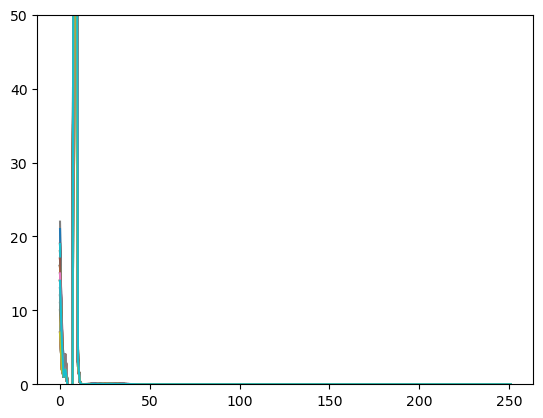

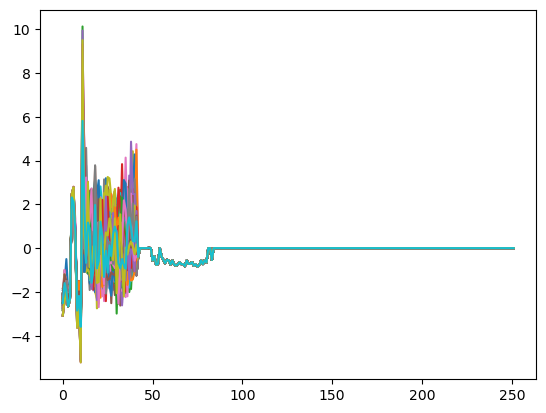

In [2]:
import matplotlib.pyplot as plt 

# write_scalar = True
# if write_scalar: 
#   scaler = StandardScaler()
#   scaler.fit(repr_traji)
#   pickle.dump(scaler, open("StandardScaler_model.pkl", "wb"))

plt.plot(repr_traji.T)
plt.ylim([0,50])
plt.show()
plt.plot(pkl_scaled.T)
plt.show()

In [2]:
print(repr_traji[-1].reshape((6,-1)))

representations.compute_similarity(repr_traji[0], repr_traji[-1])

for i, j in enumerate(repr_traji[-1].tolist()):
  print(i,j)

[[1.40000000e+01 6.00000000e+00 1.00000000e+00 ... 1.23966942e-02
  6.19834711e-03 6.19834711e-03]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
Chem contribution   :    1.00  0.00  0.00  0.00  0.00  0.00
VP contribution     :    0.92  0.00  0.00  0.00  0.00  0.00
Weights             :    1.00  0.50  0.15  0.10  0.10  0.05
Contribution        :    0.96  0.00  0.00  0.00  0.00  0.00
Similarity          :  0.9575784146526646 

0 14.0
1 6.0
2 1.0
3 2.0
4 0.20108449525655822
5 -0.7928496985073867
6 -8.61204533618629
7 0.3075572766359322
8 134.24062

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Chem contribution   :    1.00  1.00  0.00  0.00  0.00  0.00
VP contribution     :    1.00  1.00  0.00  0.00  0.00  0.00
Weights             :   16.00  0.00  0.00  0.00  0.00  0.00
Contribution(real)  :    1.00  0.00  0.00  0.00  0.00  0.00
Final Similarity    :  1.0 

Chem contribution   :    0.98  1.00  0.00  0.00  0.00  0.00
VP contribution     :    0.16  1.00  0.00  0.00  0.00  0.00
Weights             :   16.00  0.00  0.00  0.00  0.00  0.00
Contribution(real)  :    0.57  0.00  0.00  0.00  0.00  0.00
Final Similarity    :  0.5690231948385694 

Chem contribution   :    0.99  1.00  0.00  0.00  0.00  0.00
VP contribution     :   -0.35  1.00  0.00  0.00  0.00  0.00
Weights             :   14.00  0.00  0.00  0.00  0.00  0.00
Contribution(real)  :    0.32  0.00  0.00  0.00  0.00  0.00
Final Similarity    :  0.3201317309231

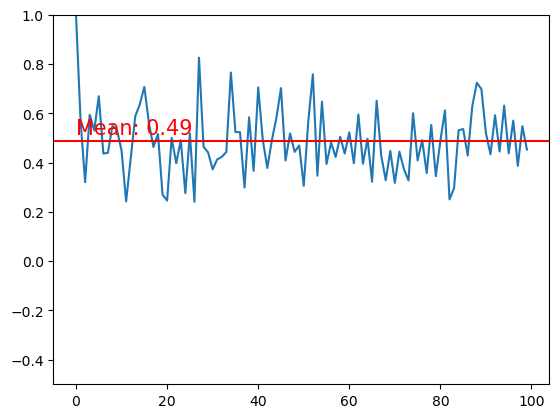

In [1]:
from scipy.spatial import distance
import matplotlib.pyplot as plt 
import numpy as np 
import pickle 

from BetaPose import representations 

# Load the data
with open('TEMP_DATA.pkl', 'rb') as f:
  # Write the object to the file
  thedict = pickle.load(f)
  repr_traji = thedict["repr"]
  
# standardize the data
pkl_model = pickle.load(open("StandardScaler_model.pkl", "rb"))
pkl_scaled = pkl_model.transform(repr_traji)

sims = [representations.compute_similarity(pkl_scaled[0], pkl_scaled[i], representations.weight(repr_traji[i])) for i in range(len(pkl_scaled))]
print("Mean of similarity values: ", np.mean(sims).round(3))

plt.plot(sims)
plt.axhline(y=np.mean(sims), color="r", linestyle="-")
plt.ylim([-0.5,1])
plt.text(0.02, 0.5, f'Mean: {np.mean(sims):.2f}', verticalalignment='bottom', horizontalalignment='left', color='r', fontsize=15)

plt.show()


# The single residue test 

In [2]:
import time, builtins, tempfile, datetime, os, pickle 

import open3d as o3d
import pytraj as pt 
import numpy as np 

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

from BetaPose import trajloader, utils
from BetaPose import features, featurizer, representations

FEATURIZER_PARMS = {
  # Mask of components 
  "MASK_INTEREST" : ":LIG,MDL", 
  "MASK_ENVIRONMENT" : ":1-221",
  
  # POCKET SETTINGS
  "VOXEL_DIMENSION" : [12, 12, 12],    # Unit: 1 (Number of lattice in one dimension)
  "CUBOID_LENGTH" : [8,8,8],           # Unit: Angstorm (Need scaling)
  
  # SEARCH SETTINGS
  "UPDATE_INTERVAL" : 1, 
  "CUTOFF": 18, 
}

# Load multiple trajectories
trajs = "/media/yzhang/MieT5/BetaPose_trajs/C209CsDJQucZ_job_001_traj.nc%/media/yzhang/MieT5/BetaPose_trajs/C209CsDJQucZ_job_002_traj.nc%/media/yzhang/MieT5/BetaPose_trajs/C209CsDJQucZ_job_003_traj.nc%/media/yzhang/MieT5/BetaPose_trajs/C209CsDJQucZ_job_004_traj.nc%/media/yzhang/MieT5/BetaPose_trajs/C209CsDJQucZ_job_005_traj.nc%/media/yzhang/MieT5/BetaPose_trajs/C209CsDJQucZ_job_006_traj.nc%/media/yzhang/MieT5/BetaPose_trajs/C209CsDJQucZ_job_007_traj.nc%/media/yzhang/MieT5/BetaPose_trajs/C209CsDJQucZ_job_008_traj.nc%/media/yzhang/MieT5/BetaPose_trajs/C209CsDJQucZ_job_009_traj.nc%/media/yzhang/MieT5/BetaPose_trajs/C209CsDJQucZ_job_010_traj.nc%"
tops = ["/media/yzhang/MieT5/BetaPose_trajs/C209CsDJQucZ_job_008_END.pdb"] * 10
trajs = trajs.strip("%").split("%")

reslist = range(45, 145)
# reslist = ["SER"]

repr_traji = []
for resid in reslist: 
  trajectories = trajloader.TrajectoryLoader(trajs, tops, mask=f":{resid}"); 
  for traj in trajectories: 
    # Complete the trajectory information
    try: 
      traj.strip(":T3P")
    except: 
      pass
    print(traj.traj)
    
    # Initialize the featurizer since different trajectory might have distinct parameters
    feat   = featurizer.Featurizer3D(FEATURIZER_PARMS); 
    feature_mass = features.MassFeature(); 
    # NOTE: in this step, the feature hooks back the feature and could access the featurizer by feat.featurer

    feat.register_feature(feature_mass)   # i features
    feat.register_traj(traj)

    print("Processing ====>", list(traj.top.residues)[0])
    # Fix the frame and iterate different resiudes
    feat.register_frames([42]) 
    if isinstance(resid, str): 
      repri, _, _ = feat.run_by_atom(traj.top.select(f"@CA&:{resid}"), fbox_length=[6,6,6])
    else: 
      repri, _, _ = feat.run_by_atom(traj.top.select(f"@CA&:1"), fbox_length=[6,6,6])
    repr_traji += repri.tolist()
    
    break
  
repr_traji = np.asarray(repr_traji)

import pickle 
thedict = {
  "repr":repr_traji, 
  "fpfh":fpfh_traji, 
  "features":features_traji
}

# Write the object to the file
pickle.dump(thedict, open('TEMP_DATA.pkl', 'wb'))  
print("Finished")


pytraj.Trajectory, 1001 frames: 
Size: 0.000380 (GB)
<Topology: 17 atoms, 1 residues, 1 mols, PBC with box type = cubic>
           
Processing ====> <GLN44, 17 atoms>
23-05-26T16:06:11   : [6 6 6]
23-05-26T16:06:11   : Frame 42: Generated 1 centers
Chargebytraj   : All atoms are kept after applying the mask. Please make sure if this is wanted.
DACbytraj      : All atoms are kept after applying the mask. Please make sure if this is wanted.
(1, 252) (1, 33, 600) (1, 1, 12, 12, 12)
pytraj.Trajectory, 1001 frames: 
Size: 0.000492 (GB)
<Topology: 22 atoms, 1 residues, 1 mols, PBC with box type = cubic>
           
Processing ====> <LYS45, 22 atoms>
23-05-26T16:06:11   : [6 6 6]
23-05-26T16:06:11   : Frame 42: Generated 1 centers
Chargebytraj   : All atoms are kept after applying the mask. Please make sure if this is wanted.
DACbytraj      : All atoms are kept after applying the mask. Please make sure if this is wanted.
(1, 252) (1, 33, 600) (1, 1, 12, 12, 12)
pytraj.Trajectory, 1001 frames

DACbytraj      : All atoms are kept after applying the mask. Please make sure if this is wanted.
(1, 252) (1, 33, 600) (1, 1, 12, 12, 12)
pytraj.Trajectory, 1001 frames: 
Size: 0.000246 (GB)
<Topology: 11 atoms, 1 residues, 1 mols, PBC with box type = cubic>
           
Processing ====> <SER62, 11 atoms>
23-05-26T16:06:14   : [6 6 6]
23-05-26T16:06:14   : Frame 42: Generated 1 centers
Chargebytraj   : All atoms are kept after applying the mask. Please make sure if this is wanted.
DACbytraj      : All atoms are kept after applying the mask. Please make sure if this is wanted.
(1, 252) (1, 33, 600) (1, 1, 12, 12, 12)
pytraj.Trajectory, 1001 frames: 
Size: 0.000358 (GB)
<Topology: 16 atoms, 1 residues, 1 mols, PBC with box type = cubic>
           
Processing ====> <VAL63, 16 atoms>
23-05-26T16:06:14   : [6 6 6]
23-05-26T16:06:14   : Frame 42: Generated 1 centers
Chargebytraj   : All atoms are kept after applying the mask. Please make sure if this is wanted.
DACbytraj      : All atoms are

DACbytraj      : All atoms are kept after applying the mask. Please make sure if this is wanted.
(1, 252) (1, 33, 600) (1, 1, 12, 12, 12)
pytraj.Trajectory, 1001 frames: 
Size: 0.000268 (GB)
<Topology: 12 atoms, 1 residues, 1 mols, PBC with box type = cubic>
           
Processing ====> <ASP80, 12 atoms>
23-05-26T16:06:18   : [6 6 6]
23-05-26T16:06:18   : Frame 42: Generated 1 centers
Chargebytraj   : All atoms are kept after applying the mask. Please make sure if this is wanted.
DACbytraj      : All atoms are kept after applying the mask. Please make sure if this is wanted.
(1, 252) (1, 33, 600) (1, 1, 12, 12, 12)
pytraj.Trajectory, 1001 frames: 
Size: 0.000157 (GB)
<Topology: 7 atoms, 1 residues, 1 mols, PBC with box type = cubic>
           
Processing ====> <GLY81, 7 atoms>
23-05-26T16:06:18   : [6 6 6]
23-05-26T16:06:18   : Frame 42: Generated 1 centers
Chargebytraj   : All atoms are kept after applying the mask. Please make sure if this is wanted.
DACbytraj      : All atoms are k

(1, 252) (1, 33, 600) (1, 1, 12, 12, 12)
pytraj.Trajectory, 1001 frames: 
Size: 0.000425 (GB)
<Topology: 19 atoms, 1 residues, 1 mols, PBC with box type = cubic>
           
Processing ====> <ILE97, 19 atoms>
23-05-26T16:06:21   : [6 6 6]
23-05-26T16:06:21   : Frame 42: Generated 1 centers
Chargebytraj   : All atoms are kept after applying the mask. Please make sure if this is wanted.
DACbytraj      : All atoms are kept after applying the mask. Please make sure if this is wanted.
(1, 252) (1, 33, 600) (1, 1, 12, 12, 12)
pytraj.Trajectory, 1001 frames: 
Size: 0.000425 (GB)
<Topology: 19 atoms, 1 residues, 1 mols, PBC with box type = cubic>
           
Processing ====> <LEU98, 19 atoms>
23-05-26T16:06:21   : [6 6 6]
23-05-26T16:06:21   : Frame 42: Generated 1 centers
Chargebytraj   : All atoms are kept after applying the mask. Please make sure if this is wanted.
DACbytraj      : All atoms are kept after applying the mask. Please make sure if this is wanted.
(1, 252) (1, 33, 600) (1, 1, 1

pytraj.Trajectory, 1001 frames: 
Size: 0.000470 (GB)
<Topology: 21 atoms, 1 residues, 1 mols, PBC with box type = cubic>
           
Processing ====> <TYR114, 21 atoms>
23-05-26T16:06:25   : [6 6 6]
23-05-26T16:06:25   : Frame 42: Generated 1 centers
Chargebytraj   : All atoms are kept after applying the mask. Please make sure if this is wanted.
DACbytraj      : All atoms are kept after applying the mask. Please make sure if this is wanted.
(1, 252) (1, 33, 600) (1, 1, 12, 12, 12)
pytraj.Trajectory, 1001 frames: 
Size: 0.000492 (GB)
<Topology: 22 atoms, 1 residues, 1 mols, PBC with box type = cubic>
           
Processing ====> <LYS115, 22 atoms>
23-05-26T16:06:25   : [6 6 6]
23-05-26T16:06:25   : Frame 42: Generated 1 centers
Chargebytraj   : All atoms are kept after applying the mask. Please make sure if this is wanted.
DACbytraj      : All atoms are kept after applying the mask. Please make sure if this is wanted.
(1, 252) (1, 33, 600) (1, 1, 12, 12, 12)
pytraj.Trajectory, 1001 fram

pytraj.Trajectory, 1001 frames: 
Size: 0.000336 (GB)
<Topology: 15 atoms, 1 residues, 1 mols, PBC with box type = cubic>
           
Processing ====> <GLU131, 15 atoms>
23-05-26T16:06:28   : [6 6 6]
23-05-26T16:06:28   : Frame 42: Generated 1 centers
Chargebytraj   : All atoms are kept after applying the mask. Please make sure if this is wanted.
DACbytraj      : All atoms are kept after applying the mask. Please make sure if this is wanted.
(1, 252) (1, 33, 600) (1, 1, 12, 12, 12)
pytraj.Trajectory, 1001 frames: 
Size: 0.000537 (GB)
<Topology: 24 atoms, 1 residues, 1 mols, PBC with box type = cubic>
           
Processing ====> <TRP132, 24 atoms>
23-05-26T16:06:28   : [6 6 6]
23-05-26T16:06:28   : Frame 42: Generated 1 centers
Chargebytraj   : All atoms are kept after applying the mask. Please make sure if this is wanted.
DACbytraj      : All atoms are kept after applying the mask. Please make sure if this is wanted.
(1, 252) (1, 33, 600) (1, 1, 12, 12, 12)
pytraj.Trajectory, 1001 fram

NameError: name 'fpfh_traji' is not defined

# Rotate of a single residue

# Same Center 
----
- Similar chemical context since trajectory is aligned
- Iterate different frames with one center 
----
- Expect minor changes

'd41d8cd98f00b204e9800998ecf8427e'

# Different Atom Selection
----
- Different chemical context
- Iterate different context within one frame
----
- Expect significant change

# Viewpoint Feature histogram


In [ ]:
import numpy as np

def compute_vfh(points, normals, viewpoint, bins=45):
  # Compute the centroid
  centroid = np.mean(points, axis=0); 
  # Compute the direction from the centroid to each point
  directions = viewpoint - centroid; 
  # Compute the angles between the directions and the normals
  angles = np.arccos(np.sum(normals * directions, axis=1) / np.linalg.norm(directions, axis=1))
  # Compute the viewpoint component histogram
  vfh_hist_viewpoint, _ = np.histogram(angles, bins=bins, range=(0, np.pi))

  # Compute the Extended FPFH component for each point
  extended_fpfh = np.zeros((len(points), bins))

  for i, (point, normal) in enumerate(zip(points, normals)):
      k_neighbors = np.arange(len(points))
      k_neighbors = k_neighbors[k_neighbors != i]
      extended_fpfh[i] = compute_pfh(points, normals, i, k_neighbors, bins)

  # Compute the Extended FPFH histogram by summing up the histograms for all points
  vfh_hist_extended = np.sum(extended_fpfh, axis=0)

  # Normalize the histograms
  vfh_hist_viewpoint = vfh_hist_viewpoint / np.sum(vfh_hist_viewpoint)
  vfh_hist_extended = vfh_hist_extended / np.sum(vfh_hist_extended)

  # Concatenate the viewpoint and extended histograms to form the VFH
  vfh = np.concatenate((vfh_hist_viewpoint, vfh_hist_extended))

  return vfh


# Rotate the protein structure

In [32]:
import matplotlib.pyplot as plt 
import time


class VFH(object):
  """
  Parent class for PFH
  """

  def __init__(self, div, nneighbors, rad):
    """
    Pass in parameters
    """
    self._div = div
    self._nneighbors = nneighbors
    self._radius = rad

    self._error_list = []
    self._Rlist = []
    self._tlist = []
    self._pcd = np.array([])
    print("After initializaiton");

  def push_pcd(self, pcd, norm):
    if len(self._pcd) > 0:
      self._pcd = np.vstack(self._pcd, pcd);
      self._norm = np.vstack(self._norm, norm);
    else:
      self._pcd = np.array(pcd);
      self._norm = np.array(norm);
    self.N = len(self._pcd);
    self._kdtree = spatial.KDTree(self._pcd);

  def get_neighbors(self, pq):
    """
    Get k nearest neighbors of the query point pq from pc within the radius using KDTree.

    :param pq: Query point (1D numpy array of shape (3,))
    :param pc: Point cloud (2D numpy array of shape (N, 3))
    :return: Indices of the k nearest neighbors within the radius, distances of the k nearest neighbors
    """

    distances, indices = self._kdtree.query(pq, k=self._nneighbors+1, distance_upper_bound=self._radius)
    # Filter out neighbors with infinite distance (outside the search radius)
    valid_neighbors = np.isfinite(distances)
    indices = indices[valid_neighbors]
    distances = distances[valid_neighbors]
    return distances, indices

  def compute_fpfh(self):
    
    pass
  
  def compute_efpfh(self):
    pcd_center = np.mean(self._pcd, axis=0);

    for point_idx in range(self.N):
      pi = self._pcd[point_idx];
      ni = self._norm[point_idx];
      
      _, neighbor_idx = self.get_neighbors(pi);
      neighbors = neighbor_idx.tolist(); 
      neighbors.remove(point_idx);    # Remove the original query point
      # print(f"#### {len(neighbor_idx)} points queried")
      # print(point_idx, "=>" , neighbors)
      for nb_idx in neighbors: 
        u = self._norm[nb_idx]; 
        v = np.cross(pi-pcd_center, u)
        w = np.cross(u, v)
        dist = np.linalg.norm(vc)

        alpha = np.dot(v, u)
        phi = np.dot(u, vc)
        theta = np.arctan(np.dot(w, u) / np.dot(u, u))
        
  def compute_vpc(self, viewpoint, bins=128): 
    
    # Compute the relative position of the viewpoint to each point in the cloud
    rel_viewpoint = np.asarray(viewpoint) - self._pcd.mean(axis=0)
    print(rel_viewpoint)

    # Normalize the relative viewpoint vectors
    rel_viewpoint_normalized = rel_viewpoint / np.linalg.norm(rel_viewpoint) #[:, np.newaxis]
    print(rel_viewpoint_normalized, rel_viewpoint_normalized.shape)

    # Calculate the angle between the normals and the relative viewpoint vectors
    cos_angles = np.sum(self._norm * rel_viewpoint_normalized, axis=1)
    angles = np.arccos(cos_angles)
    
    print(np.dot(self._norm, rel_viewpoint_normalized))
    for i in self._norm: 
      print(np.dot(i, rel_viewpoint_normalized))

    # Create the viewpoint component histogram
    hist, _ = np.histogram(angles, bins=bins, range=(0, np.pi))

    # Normalize the histogram
    hist_normalized = hist / np.sum(hist)
#     plt.plot(np.arange(len(hist_normalized)), hist_normalized)
#     plt.show()
    return hist_normalized

        


div = 2
nneighbors = 8
rad = 0.8

import open3d as o3d
import numpy as np
from scipy import spatial

mesh = o3d.io.read_triangle_mesh("/media/yzhang/MieT5/BetaPose/tests/test.ply")

pcd = np.array(mesh.vertices)
# [1200:1800]
norms = np.array(mesh.vertex_normals)
# [1200:1800]
print(pcd.shape, norms.shape)

vfh_container = VFH(div, nneighbors, rad)
vfh_container.push_pcd(pcd, norms); 
print(pcd)

# vfh_container.calc_viewpoint([10,10,10])
# vfh_container.testvfh2([10,10,10])
vfh_container.compute_vpc([10,10,10])

# st = time.perf_counter()
# for i in range(1000): 
#   vfh_container.testvfh2([10,10,10])
# print(time.perf_counter() - st); 






(1390, 3) (1390, 3)
After initializaiton
[[26.198 36.691 27.022]
 [26.539 36.543 27.084]
 [27.075 35.093 28.329]
 ...
 [25.278 32.841 25.679]
 [25.278 33.361 25.679]
 [25.159 33.101 26.13 ]]
[-20.25565252 -25.68393525 -18.78254748]
[-0.53701134 -0.68092422 -0.49795685] (3,)
[0.52718426 0.5938493  0.50031737 ... 0.83792112 0.52964206 0.53701134]
0.5271842627685688
0.5938492969508882
0.5003173683467622
0.8732540340468018
0.7816073270795973
0.8173920929446075
0.5668221641191383
0.5322932213596699
0.8792227776861242
-0.021205475849279898
-0.4741820873481106
0.1945349586270783
-0.20987448735078806
-0.7908499102819864
-0.5163115634085433
-0.34434778788964315
-0.7104123318205928
0.5334592254645619
-0.1406797840771912
0.33179730528938844
0.7582596151272685
-0.41936701288798606
-0.00335659706607333
0.24561628415221654
-0.06160551709695791
0.23233380824172234
0.4985848355839647
0.28718537433198266
0.46085053480574456
0.7015156956252413
0.536571099753376
0.43618392046274773
0.5128476647820629
0.4

array([0.        , 0.        , 0.00071942, 0.00143885, 0.00215827,
       0.00071942, 0.00143885, 0.00215827, 0.00503597, 0.00143885,
       0.00143885, 0.        , 0.00431655, 0.0057554 , 0.00431655,
       0.00791367, 0.0028777 , 0.00431655, 0.00359712, 0.0057554 ,
       0.00647482, 0.00647482, 0.00647482, 0.00719424, 0.00359712,
       0.01007194, 0.01007194, 0.01151079, 0.00863309, 0.00647482,
       0.01079137, 0.00719424, 0.01079137, 0.00791367, 0.00863309,
       0.00719424, 0.01079137, 0.01151079, 0.00863309, 0.01223022,
       0.01007194, 0.01366906, 0.00863309, 0.01366906, 0.01366906,
       0.00719424, 0.01079137, 0.00863309, 0.00647482, 0.01151079,
       0.01007194, 0.00647482, 0.01438849, 0.01079137, 0.00863309,
       0.00935252, 0.01079137, 0.01510791, 0.00863309, 0.01726619,
       0.01366906, 0.01438849, 0.01582734, 0.01223022, 0.01079137,
       0.00791367, 0.00935252, 0.01007194, 0.01582734, 0.00791367,
       0.01582734, 0.01151079, 0.01726619, 0.0057554 , 0.01223